## GB_Fx-Monthly_panel-LOFO



Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['SP500', 'StoxEurope', 'd_pi', 'VIX', 'dI_t', 'EUR_NOK', 'OSEBX', 'Q', 'OBX_Energy', 'Brent']

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<=max_lags

=== Model performance (monthly mean, EUR/NOK – XGB panel + past macros) ===
Observations: 309
RMSE (level): 0.148001
MAE  (level): 0.099350
Directional accuracy: 209/308 (67.9%)

=== Diebold–Mariano vs Random Walk (monthly) ===
Loss: MSE | horizon h=1
DM-statistic: -2.2063
p-value     : 0.0274

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<=max_lags

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<=max_lags

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<=max_lags

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<=max_lags

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: 

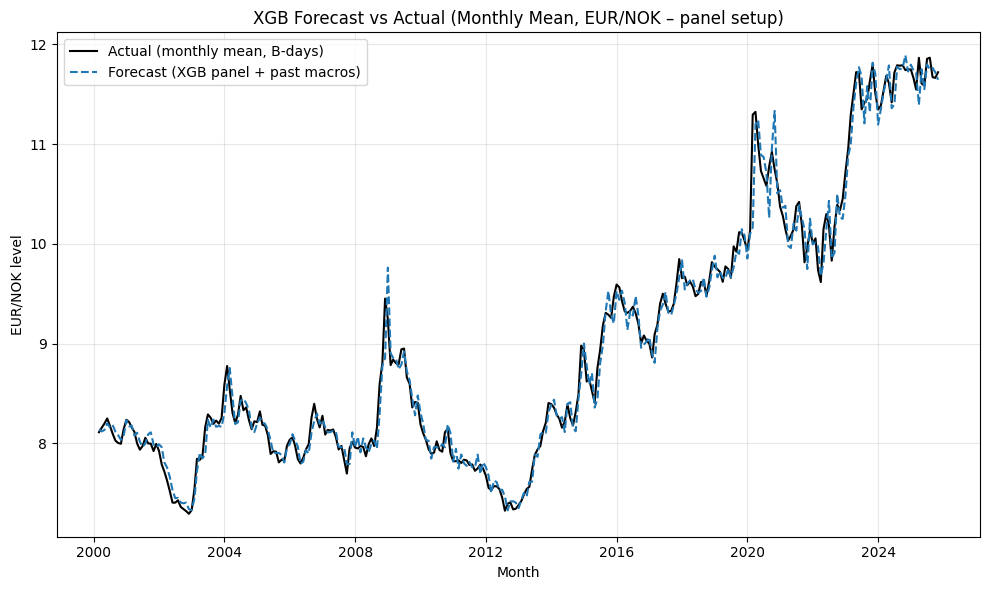

In [1]:
# =========================================
# XGB Price only – EUR/NOK walk-forward (monthly, levels)
# with daily panel + macro covariates (past-only), FULL dataset
#
# Past-covariate panel setup:
#   - Target: EUR_NOK (single series)
#   - Panel predictors: Brent, VIX, StoxEurope, SP500, OSEBX, OBX_Energy + EUR_NOK lags
#   - Macros: Q, d_pi, dI_t as past-only covariates
#   - Data: daily (calendar days), forward-filled
#   - Cut: last business day of previous month (based on EUR_NOK B-days)
#   - Forecast: recursive daily next-month -> aggregate to monthly mean over business days
#   - No future covariate paths -> all non-target predictors frozen at last observed level
#   - Model: XGBRegressor one-step on lagged predictors, fitted on ALL history up to cut
#   - Metrics: Observations, RMSE, MAE, Directional accuracy
#   - Test: Diebold–Mariano vs Random Walk (MSE, h=1)
#   - Importance: DM p-value leave-one-out covariate importance
#   - Plot: show only (no saving)
#   - Constraint: n_estimators <= 150
# =========================================

!pip -q install pandas numpy scikit-learn matplotlib requests certifi joblib xgboost

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List

import numpy as np
import pandas as pd
import requests, certifi
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed


# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )

    m_freq: str = "M"
    max_lags: int = 20
    max_horizon: int = 64  # safety cap; months ~31 days

    # XGB hyperparameters with 150-tree cap
    n_estimators: int = 150
    learning_rate: float = 0.08
    max_depth: int = 3
    subsample: float = 0.8
    colsample_bytree: float = 0.8
    min_child_weight: float = 3.0
    gamma: float = 0.05
    reg_alpha: float = 0.0
    reg_lambda: float = 2.0
    random_state: int = 42

    retries: int = 3
    timeout: int = 60
    verbose: bool = True

CFG = Config()

TARGET_SERIES = "EUR_NOK"
PANEL_SERIES = [
    "EUR_NOK",
    "Brent",
    "VIX",
    "StoxEurope",
    "SP500",
    "OSEBX",
    "OBX_Energy",
]
MACRO_COLS = ["Q", "d_pi", "dI_t"]

ALL_PREDICTORS = PANEL_SERIES + MACRO_COLS  # all lagged predictors


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with simple retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading: daily wide DF + EUR_NOK business-day series
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Expected columns:
      Date, EUR_NOK, Q, d_pi, dI_t,
      Brent, VIX, StoxEurope, SP500, OSEBX, OBX_Energy

    Returns:
      S_b  : EUR_NOK on business days (B) with ffill (cuts + truth)
      DF_d : daily (D) wide DataFrame with PANEL_SERIES + MACRO_COLS,
             calendar days, forward-filled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date"} | set(ALL_PREDICTORS)
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    for col in ALL_PREDICTORS:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    if df.empty:
        raise ValueError("Dataset is empty after cleaning.")

    # Business-day EUR_NOK (truth/aggregation base)
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily wide DF_d (calendar days, ffill)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return the last business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# Feature engineering: multivariate lag matrix
# -----------------------------
def make_lag_matrix(
    df_hist: pd.DataFrame,
    predictors: List[str],
    max_lags: int
) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Build X, y for one-step ahead daily forecasting of EUR_NOK.

    X_t = stacked lags of all predictors:
      [pred1_{t-1..t-L}, pred2_{t-1..t-L}, ...]
    y_t = EUR_NOK_t
    """
    work = df_hist[predictors].copy()
    lag_cols: List[str] = []

    for var in predictors:
        for k in range(1, max_lags + 1):
            name = f"{var}_lag{k}"
            work[name] = work[var].shift(k)
            lag_cols.append(name)

    work = work.dropna()
    X = work[lag_cols].values
    y = work[TARGET_SERIES].values
    return X, y, lag_cols


# -----------------------------
# XGBoost one-step model (fit on all history up to cut)
# -----------------------------
def fit_xgb_one_step(df_hist_daily: pd.DataFrame, predictors: List[str]) -> Tuple[XGBRegressor, List[str]]:
    """Fit XGB for one-step daily prediction using lags of predictors (no val split)."""
    X, y, lag_cols = make_lag_matrix(df_hist_daily, predictors, CFG.max_lags)

    if len(X) < 5:
        raise ValueError("Too few observations after lagging to fit model.")

    model = XGBRegressor(
        n_estimators=CFG.n_estimators,  # <=150 always
        learning_rate=CFG.learning_rate,
        max_depth=CFG.max_depth,
        subsample=CFG.subsample,
        colsample_bytree=CFG.colsample_bytree,
        min_child_weight=CFG.min_child_weight,
        gamma=CFG.gamma,
        reg_alpha=CFG.reg_alpha,
        reg_lambda=CFG.reg_lambda,
        objective="reg:squarederror",
        eval_metric="rmse",
        tree_method="hist",
        random_state=CFG.random_state,
        n_jobs=1
    )
    model.fit(X, y)
    return model, lag_cols


def recursive_daily_forecast(
    model: XGBRegressor,
    df_hist_daily: pd.DataFrame,
    predictors: List[str],
    H: int
) -> pd.Series:
    """
    Produce H daily forecasts recursively.

    Anti-leakage:
      - all non-target predictors frozen at last observed level
      - only EUR_NOK updated
    """
    hist = df_hist_daily[predictors].copy()
    last_vals = hist.iloc[-1].to_dict()  # frozen predictors snapshot

    preds = []
    for _ in range(H):
        if len(hist) < CFG.max_lags:
            raise ValueError("Not enough history for lag features.")

        row_feats = []
        for var in predictors:
            lags = hist[var].iloc[-CFG.max_lags:][::-1].values  # [t-1,...,t-L]
            row_feats.extend(lags.tolist())

        x = np.array(row_feats, dtype=float).reshape(1, -1)
        yhat = float(model.predict(x)[0])
        preds.append(yhat)

        new_row = last_vals.copy()
        new_row[TARGET_SERIES] = yhat
        new_idx = hist.index[-1] + pd.Timedelta(days=1)
        hist = pd.concat([hist, pd.DataFrame([new_row], index=[new_idx])])

    return pd.Series(preds)


# -----------------------------
# Monthly walk-forward using XGB + panel/macros (past-only)
# PARALLEL outer loop
# -----------------------------
def walk_forward_xgb_monthly_panel_pastcov_parallel(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    predictors: List[str],
    n_jobs_outer: int = -1,
    backend: str = "loky"
) -> pd.DataFrame:
    """
    For each calendar month m:
      - cut at last business day of previous month
      - fit XGB on daily history up to cut
      - recursively forecast full next month daily
      - aggregate to business-day monthly mean and compare to truth
    """
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(), freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    def _process_one_month(m: pd.Period):
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            return (str(m), None, "no_cut_in_prev_month")

        hist_df = DF_d.loc[:cut]
        if hist_df.shape[0] <= CFG.max_lags:
            return (str(m), None, "hist<=max_lags")

        # Business days in target month
        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            return (str(m), None, "no_bdays_in_month")
        y_true = float(S_b.loc[idx_m_b].mean())

        # Horizon = full calendar month length
        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            return (str(m), None, f"horizon_invalid(H={H})")

        model, _ = fit_xgb_one_step(hist_df, predictors)
        pf = recursive_daily_forecast(model, hist_df, predictors, H)

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf.values, index=f_idx, name="point")

        # Aggregate to business-day mean
        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            return (str(m), None, "no_overlap_pred_B_days")
        y_pred = float(pred_b.dropna().mean())

        row = {"month": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}
        return (str(m), row, None)

    results = Parallel(n_jobs=n_jobs_outer, backend=backend)(
        delayed(_process_one_month)(m) for m in months
    )

    rows: Dict[str, dict] = {}
    dropped: Dict[str, str] = {}
    for key, row, reason in results:
        if row is not None:
            rows[key] = row
        else:
            dropped[key] = reason or "unknown"

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if str(m) not in rows]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")

    return df


# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate(eval_df: pd.DataFrame, silent: bool = False) -> pd.DataFrame:
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    if not silent:
        print("\n=== Model performance (monthly mean, EUR/NOK – XGB panel + past macros) ===")
        print(f"Observations: {n_obs}")
        print(f"RMSE (level): {rmse:.6f}")
        print(f"MAE  (level): {mae:.6f}")
        if total:
            print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core


# -----------------------------
# Diebold–Mariano (vs Random Walk)
# -----------------------------
def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse"
) -> Tuple[float, float]:
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> Tuple[float, float]:
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (monthly) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")
    return dm_stat, p_val


# -----------------------------
# DM p-value importance (leave-one-out)
# -----------------------------
def dm_pvalue_for_covset(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    predictors: List[str],
    silent_eval: bool = True,
) -> Tuple[float, float]:
    """
    Run full walk-forward for a given predictor set and return DM-stat and p-value.
    """
    df_eval = walk_forward_xgb_monthly_panel_pastcov_parallel(S_b, DF_d, predictors)
    ev = evaluate(df_eval, silent=silent_eval)
    ev["rw_pred"] = ev["y_true"].shift(1)
    dm_stat, p_val = dm_test(ev["y_true"], ev["y_pred"], ev["rw_pred"], h=1, loss="mse")
    return dm_stat, p_val


def pvalue_importance_leave_one_out(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    full_predictors: List[str],
) -> Tuple[float, float, pd.DataFrame]:
    """
    Leave-one-out importance:
      - Baseline DM p-value with all predictors
      - For each predictor: remove it, re-run, compute p_without
      - delta_p = p_without - p_baseline
    Larger delta_p => predictor contributes more to lowering p.
    """
    base_stat, base_p = dm_pvalue_for_covset(S_b, DF_d, full_predictors)

    rows = []
    # Vi vurderer kun kovariater utover target selv for importance,
    # men du kan endre dette ved å fjerne if-blokken.
    candidates = [c for c in full_predictors if c != TARGET_SERIES]

    for c in candidates:
        reduced = [x for x in full_predictors if x != c]
        stat_i, p_i = dm_pvalue_for_covset(S_b, DF_d, reduced)

        rows.append({
            "covariate": c,
            "p_without": p_i,
            "delta_p": p_i - base_p,
            "dm_without": stat_i
        })

    out = (
        pd.DataFrame(rows)
        .sort_values("delta_p", ascending=False)
        .reset_index(drop=True)
    )
    return base_stat, base_p, out


# -----------------------------
# Plot (show only, no saving)
# -----------------------------
def plot_monthly_simple(eval_df: pd.DataFrame):
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (monthly mean, B-days)")
    plt.plot(
        x, eval_df["y_pred"], color="tab:blue", linestyle="--",
        label="Forecast (XGB panel + past macros)"
    )

    plt.title("XGB Forecast vs Actual (Monthly Mean, EUR/NOK – panel setup)")
    plt.xlabel("Month")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# -----------------------------
# Main
# -----------------------------
def main():
    S_b, DF_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    # 1) Baseline med alle predictors
    df_eval_base = walk_forward_xgb_monthly_panel_pastcov_parallel(
        S_b, DF_d, ALL_PREDICTORS, n_jobs_outer=-1
    )
    eval_df_base = evaluate(df_eval_base, silent=False)

    base_stat, base_p = dm_against_random_walk(eval_df_base, loss="mse", h=1)

    # 2) Leave-one-out DM p-value importance
    base_stat2, base_p2, p_imp = pvalue_importance_leave_one_out(
        S_b, DF_d, ALL_PREDICTORS
    )

    print("\n=== DM p-value importance (leave-one-out) ===")
    print(f"Baseline DM-stat: {base_stat2:.4f} | p={base_p2:.4f}\n")
    if not p_imp.empty:
        print(p_imp.to_string(index=False))
    else:
        print("Ingen kandidater for importance (sjekk predictors-listen).")

    # 3) Plot baseline (ingen lagring)
    plot_monthly_simple(eval_df_base)


if __name__ == "__main__":
    main()


In [2]:
# =========================================
# XGB Price only – EUR/NOK walk-forward (monthly, levels) with daily panel + macro covariates
# ROUND 2 (monthly):
#   - Use IMPORTANT_COV_R1 based on round-1 leave-one-out (delta_p > 0).
#   - Run baseline monthly walk-forward.
#   - Compute DM vs Random Walk (MSE, h=1).
#   - Re-run leave-one-out on IMPORTANT_COV_R1.
#   - Suggest IMPORTANT_COV_R2 as delta_p > 0 within this round.
# No plots saved.
# =========================================

!pip -q install pandas numpy scikit-learn matplotlib requests certifi joblib xgboost

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List

import numpy as np
import pandas as pd
import requests, certifi

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed


# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )

    m_freq: str = "M"
    max_lags: int = 20
    max_horizon: int = 64

    # XGB hyperparameters with 150-tree cap
    n_estimators: int = 150
    learning_rate: float = 0.08
    max_depth: int = 3
    subsample: float = 0.8
    colsample_bytree: float = 0.8
    min_child_weight: float = 3.0
    gamma: float = 0.05
    reg_alpha: float = 0.0
    reg_lambda: float = 2.0
    random_state: int = 42

    retries: int = 3
    timeout: int = 60
    verbose: bool = True

CFG = Config()

TARGET_SERIES = "EUR_NOK"

# IMPORTANT covariates from your round-1 output (delta_p > 0):
IMPORTANT_COV_R1 = ["Q", "d_pi", "dI_t", "Brent", "OSEBX", "VIX", "StoxEurope"]

# In this XGB setup, predictors are lagged versions of:
#   - EUR_NOK (target included as predictor via lags)
#   - the chosen covariates (IMPORTANT_COV_R1)
BASE_PREDICTORS_R1 = [TARGET_SERIES] + IMPORTANT_COV_R1


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading: only pulls needed cols
# -----------------------------
def load_series(url: str, predictors: List[str]) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Expected columns include Date, EUR_NOK and requested predictors.
    Returns:
      S_b  : EUR_NOK on business days (B), ffilled
      DF_d : daily (D) wide DataFrame with predictors, calendar days, ffilled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date"} | set(predictors)
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    for col in predictors:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    if df.empty:
        raise ValueError("Dataset is empty after cleaning.")

    # Business-day EUR_NOK
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily wide DF_d (calendar days)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# Feature engineering: multivariate lag matrix
# -----------------------------
def make_lag_matrix(df_hist: pd.DataFrame, predictors: List[str], max_lags: int):
    work = df_hist[predictors].copy()
    lag_cols: List[str] = []

    for var in predictors:
        for k in range(1, max_lags + 1):
            name = f"{var}_lag{k}"
            work[name] = work[var].shift(k)
            lag_cols.append(name)

    work = work.dropna()
    if work.empty:
        return np.empty((0, 0)), np.empty((0,)), lag_cols

    X = work[lag_cols].values
    y = work[TARGET_SERIES].values
    return X, y, lag_cols


# -----------------------------
# XGBoost one-step model (NO validation split, capped at 150 trees)
# -----------------------------
def fit_xgb_one_step(df_hist_daily: pd.DataFrame, predictors: List[str]):
    X, y, lag_cols = make_lag_matrix(df_hist_daily, predictors, CFG.max_lags)
    if len(X) < 5:
        raise ValueError("Too few observations after lagging to fit model.")

    model = XGBRegressor(
        n_estimators=CFG.n_estimators,
        learning_rate=CFG.learning_rate,
        max_depth=CFG.max_depth,
        subsample=CFG.subsample,
        colsample_bytree=CFG.colsample_bytree,
        min_child_weight=CFG.min_child_weight,
        gamma=CFG.gamma,
        reg_alpha=CFG.reg_alpha,
        reg_lambda=CFG.reg_lambda,
        objective="reg:squarederror",
        eval_metric="rmse",
        tree_method="hist",
        random_state=CFG.random_state,
        n_jobs=1
    )
    model.fit(X, y)
    return model, lag_cols


def recursive_daily_forecast(model: XGBRegressor, df_hist_daily: pd.DataFrame,
                             predictors: List[str], H: int) -> pd.Series:
    """
    Recursive H-step daily forecast.
    Anti-leakage rule:
      - all non-target predictors frozen at last observed level
      - only EUR_NOK updated through recursion
    """
    hist = df_hist_daily[predictors].copy()
    last_vals = hist.iloc[-1].to_dict()  # frozen snapshot

    preds = []
    for _ in range(H):
        if len(hist) < CFG.max_lags:
            raise ValueError("Not enough history for lag features.")

        row_feats = []
        for var in predictors:
            lags = hist[var].iloc[-CFG.max_lags:][::-1].values
            row_feats.extend(lags.tolist())

        x = np.array(row_feats, dtype=float).reshape(1, -1)
        yhat = float(model.predict(x)[0])
        preds.append(yhat)

        new_row = last_vals.copy()
        new_row[TARGET_SERIES] = yhat
        new_idx = hist.index[-1] + pd.Timedelta(days=1)
        hist = pd.concat([hist, pd.DataFrame([new_row], index=[new_idx])])

    return pd.Series(preds)


# -----------------------------
# Monthly walk-forward (parallel outer loop)
# -----------------------------
def walk_forward_xgb_monthly_parallel(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    predictors: List[str],
    n_jobs_outer: int = -1,
    backend: str = "loky"
) -> pd.DataFrame:
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(), freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    def _process_one_month(m: pd.Period):
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            return (str(m), None, "no_cut_in_prev_month")

        hist_df = DF_d.loc[:cut]
        if hist_df.shape[0] <= CFG.max_lags + 5:
            return (str(m), None, "hist<=max_lags")

        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            return (str(m), None, "no_bdays_in_month")
        y_true = float(S_b.loc[idx_m_b].mean())

        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            return (str(m), None, f"horizon_invalid(H={H})")

        model, _ = fit_xgb_one_step(hist_df, predictors)
        pf = recursive_daily_forecast(model, hist_df, predictors, H)

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf.values, index=f_idx, name="point")

        pred_b = pred_daily.reindex(idx_m_b)
        if pred_b.isna().all():
            return (str(m), None, "no_overlap_pred_B_days")
        y_pred = float(pred_b.dropna().mean())

        row = {"month": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}
        return (str(m), row, None)

    results = Parallel(n_jobs=n_jobs_outer, backend=backend)(
        delayed(_process_one_month)(m) for m in months
    )

    rows: Dict[str, dict] = {}
    dropped: Dict[str, str] = {}
    for key, row, reason in results:
        if row is not None:
            rows[key] = row
        else:
            dropped[key] = reason or "unknown"

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if str(m) not in rows]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")

    return df


# -----------------------------
# Evaluation / DM
# -----------------------------
def evaluate(eval_df: pd.DataFrame, silent: bool = False) -> pd.DataFrame:
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    if not silent:
        print("\n=== Model performance (monthly mean, EUR/NOK – XGB important covariates) ===")
        print(f"Observations: {n_obs}")
        print(f"RMSE (level): {rmse:.6f}")
        print(f"MAE  (level): {mae:.6f}")
        if total:
            print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core


def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def dm_test(y_true: pd.Series, y_model: pd.Series, y_rw: pd.Series,
            h: int = 1, loss: str = "mse"):
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val


def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1):
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (monthly | XGB important covariates) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")
    return dm_stat, p_val


# -----------------------------
# Leave-one-out DM p-value importance
# -----------------------------
def dm_pvalue_for_covset(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    predictors: List[str],
) -> Tuple[float, float]:
    df_eval = walk_forward_xgb_monthly_parallel(S_b, DF_d, predictors, n_jobs_outer=-1)
    ev = evaluate(df_eval, silent=True)
    ev["rw_pred"] = ev["y_true"].shift(1)
    dm_stat, p_val = dm_test(ev["y_true"], ev["y_pred"], ev["rw_pred"], h=1, loss="mse")
    return dm_stat, p_val


def pvalue_importance_leave_one_out(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    base_predictors: List[str],
    cov_cols_only: List[str],
) -> Tuple[float, float, pd.DataFrame]:
    """
    Leave-one-out on covariates only (not removing EUR_NOK lags).
    base_predictors = [EUR_NOK] + cov_cols_only
    """
    base_stat, base_p = dm_pvalue_for_covset(S_b, DF_d, base_predictors)

    rows = []
    for c in cov_cols_only:
        reduced_cov = [x for x in cov_cols_only if x != c]
        reduced_predictors = [TARGET_SERIES] + reduced_cov

        stat_i, p_i = dm_pvalue_for_covset(S_b, DF_d, reduced_predictors)
        rows.append({
            "covariate": c,
            "p_without": p_i,
            "delta_p": p_i - base_p,
            "dm_without": stat_i
        })

    out = pd.DataFrame(rows).sort_values("delta_p", ascending=False).reset_index(drop=True)
    return base_stat, base_p, out


# -----------------------------
# Main (ROUND 2)
# -----------------------------
def main():
    # Load only EUR_NOK + important covariates from R1
    predictors_r1 = BASE_PREDICTORS_R1
    S_b, DF_d = load_series(CFG.url, predictors_r1)

    if CFG.verbose:
        print(f"IMPORTANT_COV_R1: {IMPORTANT_COV_R1}")
        print(f"Predictors used (with lags): {predictors_r1}")
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    # Baseline on IMPORTANT_COV_R1
    df_eval_base = walk_forward_xgb_monthly_parallel(S_b, DF_d, predictors_r1, n_jobs_outer=-1)
    eval_df_base = evaluate(df_eval_base, silent=False)

    dm_stat_base, dm_p_base = dm_against_random_walk(eval_df_base, loss="mse", h=1)

    # Leave-one-out importance on IMPORTANT_COV_R1
    base_stat2, base_p2, p_imp = pvalue_importance_leave_one_out(
        S_b, DF_d,
        base_predictors=predictors_r1,
        cov_cols_only=IMPORTANT_COV_R1
    )

    print("\n=== DM p-value importance (leave-one-out, monthly | ROUND 2 on important set) ===")
    print(f"Baseline DM-stat: {base_stat2:.4f} | p={base_p2:.4f}\n")
    print(p_imp.to_string(index=False))

    important_r2 = p_imp.loc[p_imp["delta_p"] > 0, "covariate"].tolist()
    print(f"\nSuggested important covariates for ROUND 3 (delta_p>0): {important_r2}")


if __name__ == "__main__":
    main()


IMPORTANT_COV_R1: ['Q', 'd_pi', 'dI_t', 'Brent', 'OSEBX', 'VIX', 'StoxEurope']
Predictors used (with lags): ['EUR_NOK', 'Q', 'd_pi', 'dI_t', 'Brent', 'OSEBX', 'VIX', 'StoxEurope']
Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['StoxEurope', 'd_pi', 'VIX', 'dI_t', 'EUR_NOK', 'OSEBX', 'Q', 'Brent']

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<=max_lags

=== Model performance (monthly mean, EUR/NOK – XGB important covariates) ===
Observations: 309
RMSE (level): 0.147603
MAE  (level): 0.101076
Directional accuracy: 208/308 (67.5%)

=== Diebold–Mariano vs Random Walk (monthly | XGB important covariates) ===
Loss: MSE | horizon h=1
DM-statistic: -2.6745
p-value     : 0.0075

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<=max_lags

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<=max_lags

Dropped months and reasons:
  2000-01: no_cut_in_prev_month


Predictors (with lags): ['EUR_NOK', 'Brent', 'VIX', 'OSEBX', 'StoxEurope', 'd_pi', 'Q', 'dI_t']
Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['StoxEurope', 'd_pi', 'VIX', 'dI_t', 'EUR_NOK', 'OSEBX', 'Q', 'Brent']

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<=max_lags

=== Model performance (monthly mean, EUR/NOK – XGB Leave-one-out covariates) ===
LEAVE_ONE_OUT_COV: ['Brent', 'VIX', 'OSEBX', 'StoxEurope', 'd_pi', 'Q', 'dI_t']
Observations: 309
RMSE (level): 0.147675
MAE  (level): 0.100339
Directional accuracy: 204/308 (66.2%)

=== Diebold–Mariano vs Random Walk (monthly | Leave-one-out covariates) ===
Loss: MSE | horizon h=1
DM-statistic: -2.7142
p-value     : 0.0066


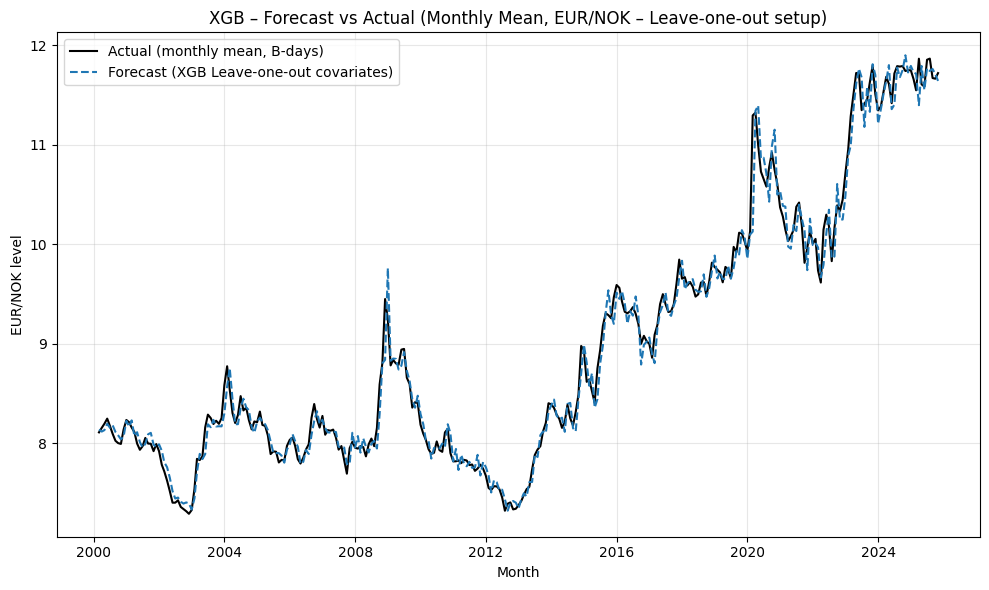

Saved PNG: XGB_PriceOnly_Monthly_LeaveOneOut.png


In [7]:
# =========================================
# XGB Price only – EUR/NOK walk-forward (monthly, levels)
# DAILY PANEL + MACRO COVARIATES (past-only, leave-one-out selected set)
#
# - Target: EUR_NOK (single series)
# - Predictors (lags): EUR_NOK + selected covariates
# - Data: daily (calendar days), forward-filled
# - Cut: last business day of previous month (based on EUR_NOK B-days)
# - Forecast: recursive daily next-month -> aggregate to monthly mean over business days
# - Past-only rule: all non-target predictors frozen at last observed level
# - Metrics: Observations, RMSE, MAE, Directional accuracy
# - Test: Diebold–Mariano vs Random Walk (MSE, h=1)
# - Plot: Actual (black) vs Forecast (blue dashed)
# - Save plot: YES
# - Constraint: n_estimators <= 150
# - History: uses ENTIRE dataset (no min_hist_days cutoff)
# - Output PNG: "XGB_PriceOnly_Monthly_LeaveOneOut.png"
# =========================================

!pip -q install pandas numpy scikit-learn matplotlib requests certifi joblib xgboost

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List

import numpy as np
import pandas as pd
import requests, certifi
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed


# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )

    m_freq: str = "M"
    max_lags: int = 20
    max_horizon: int = 64

    # XGB hyperparameters with 150-tree cap
    n_estimators: int = 150
    learning_rate: float = 0.08
    max_depth: int = 3
    subsample: float = 0.8
    colsample_bytree: float = 0.8
    min_child_weight: float = 3.0
    gamma: float = 0.05
    reg_alpha: float = 0.0
    reg_lambda: float = 2.0
    random_state: int = 42

    retries: int = 3
    timeout: int = 60
    verbose: bool = True

    fig_png: str = "XGB_PriceOnly_Monthly_LeaveOneOut.png"

CFG = Config()

TARGET_SERIES = "EUR_NOK"

# Covariates we agreed contribute (Round 2 baseline, delta_p>0)
# (Leave-one-out selected set)
LEAVE_ONE_OUT_COV = ["Brent", "VIX", "OSEBX", "StoxEurope", "d_pi", "Q", "dI_t"]

# Predictors whose lags enter X (target included)
PREDICTORS = [TARGET_SERIES] + LEAVE_ONE_OUT_COV


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading (only needed cols)
# -----------------------------
def load_series(url: str, predictors: List[str]) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Returns:
      S_b  : EUR_NOK on business days (B), ffilled
      DF_d : daily (D) wide DataFrame with predictors, calendar days, ffilled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date"} | set(predictors)
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    for col in predictors:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    if df.empty:
        raise ValueError("Dataset is empty after cleaning.")

    # Business-day EUR_NOK (truth + cut calendar)
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily wide DF (inputs)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# Feature engineering: multivariate lag matrix
# -----------------------------
def make_lag_matrix(df_hist: pd.DataFrame, predictors: List[str], max_lags: int):
    work = df_hist[predictors].copy()
    lag_cols: List[str] = []

    for var in predictors:
        for k in range(1, max_lags + 1):
            name = f"{var}_lag{k}"
            work[name] = work[var].shift(k)
            lag_cols.append(name)

    work = work.dropna()
    if work.empty:
        return np.empty((0, 0)), np.empty((0,)), lag_cols

    X = work[lag_cols].values
    y = work[TARGET_SERIES].values
    return X, y, lag_cols


# -----------------------------
# XGBoost one-step model (capped at 150 trees)
# -----------------------------
def fit_xgb_one_step(df_hist_daily: pd.DataFrame, predictors: List[str]):
    X, y, lag_cols = make_lag_matrix(df_hist_daily, predictors, CFG.max_lags)
    if len(X) < 5:
        raise ValueError("Too few observations after lagging to fit model.")

    model = XGBRegressor(
        n_estimators=CFG.n_estimators,
        learning_rate=CFG.learning_rate,
        max_depth=CFG.max_depth,
        subsample=CFG.subsample,
        colsample_bytree=CFG.colsample_bytree,
        min_child_weight=CFG.min_child_weight,
        gamma=CFG.gamma,
        reg_alpha=CFG.reg_alpha,
        reg_lambda=CFG.reg_lambda,
        objective="reg:squarederror",
        eval_metric="rmse",
        tree_method="hist",
        random_state=CFG.random_state,
        n_jobs=1
    )
    model.fit(X, y)
    return model, lag_cols


def recursive_daily_forecast(
    model: XGBRegressor,
    df_hist_daily: pd.DataFrame,
    predictors: List[str],
    H: int
) -> pd.Series:
    """
    Recursive H-step daily forecast.
    Past-only rule:
      - all non-target predictors frozen at last observed level
      - only EUR_NOK updated through recursion
    """
    hist = df_hist_daily[predictors].copy()
    last_vals = hist.iloc[-1].to_dict()

    preds = []
    for _ in range(H):
        if len(hist) < CFG.max_lags:
            raise ValueError("Not enough history for lag features.")

        row_feats = []
        for var in predictors:
            lags = hist[var].iloc[-CFG.max_lags:][::-1].values
            row_feats.extend(lags.tolist())

        x = np.array(row_feats, dtype=float).reshape(1, -1)
        yhat = float(model.predict(x)[0])
        preds.append(yhat)

        new_row = last_vals.copy()
        new_row[TARGET_SERIES] = yhat
        new_idx = hist.index[-1] + pd.Timedelta(days=1)
        hist = pd.concat([hist, pd.DataFrame([new_row], index=[new_idx])])

    return pd.Series(preds)


# -----------------------------
# Monthly walk-forward (parallel outer loop)
# -----------------------------
def walk_forward_xgb_monthly_parallel(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    predictors: List[str],
    n_jobs_outer: int = -1,
    backend: str = "loky"
) -> pd.DataFrame:
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(), freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    def _process_one_month(m: pd.Period):
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            return (str(m), None, "no_cut_in_prev_month")

        hist_df = DF_d.loc[:cut]
        # Only minimal guard: must exceed lags
        if hist_df.shape[0] <= CFG.max_lags + 1:
            return (str(m), None, "hist<=max_lags")

        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            return (str(m), None, "no_bdays_in_month")
        y_true = float(S_b.loc[idx_m_b].mean())

        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            return (str(m), None, f"horizon_invalid(H={H})")

        model, _ = fit_xgb_one_step(hist_df, predictors)
        pf = recursive_daily_forecast(model, hist_df, predictors, H)

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf.values, index=f_idx, name="point")

        pred_b = pred_daily.reindex(idx_m_b)
        if pred_b.isna().all():
            return (str(m), None, "no_overlap_pred_B_days")
        y_pred = float(pred_b.dropna().mean())

        row = {"month": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}
        return (str(m), row, None)

    results = Parallel(n_jobs=n_jobs_outer, backend=backend)(
        delayed(_process_one_month)(m) for m in months
    )

    rows: Dict[str, dict] = {}
    dropped: Dict[str, str] = {}
    for key, row, reason in results:
        if row is not None:
            rows[key] = row
        else:
            dropped[key] = reason or "unknown"

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if str(m) not in rows]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")

    return df


# -----------------------------
# Evaluation / DM
# -----------------------------
def evaluate(eval_df: pd.DataFrame, predictors_used: List[str]) -> pd.DataFrame:
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (monthly mean, EUR/NOK – XGB Leave-one-out covariates) ===")
    print(f"LEAVE_ONE_OUT_COV: {predictors_used[1:]}")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core


def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse"
):
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val


def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1):
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (monthly | Leave-one-out covariates) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")
    return dm_stat, p_val


# -----------------------------
# Plot (SAVE PNG)
# -----------------------------
def plot_monthly_simple(eval_df: pd.DataFrame, png_path: str):
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (monthly mean, B-days)")
    plt.plot(
        x, eval_df["y_pred"], color="tab:blue", linestyle="--",
        label="Forecast (XGB Leave-one-out covariates)"
    )

    plt.title("XGB – Forecast vs Actual (Monthly Mean, EUR/NOK – Leave-one-out setup)")
    plt.xlabel("Month")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved PNG: {png_path}")


# -----------------------------
# Main
# -----------------------------
def main():
    S_b, DF_d = load_series(CFG.url, PREDICTORS)

    if CFG.verbose:
        print(f"Predictors (with lags): {PREDICTORS}")
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    df_eval = walk_forward_xgb_monthly_parallel(S_b, DF_d, PREDICTORS, n_jobs_outer=-1)
    eval_df = evaluate(df_eval, predictors_used=PREDICTORS)

    dm_against_random_walk(eval_df, loss="mse", h=1)
    plot_monthly_simple(eval_df, CFG.fig_png)

if __name__ == "__main__":
    main()


## Quarterly

Covariates (ROUND 1): ['Brent', 'VIX', 'StoxEurope', 'SP500', 'OSEBX', 'OBX_Energy', 'Q', 'd_pi', 'dI_t']
Predictors used (with lags): ['EUR_NOK', 'Brent', 'VIX', 'StoxEurope', 'SP500', 'OSEBX', 'OBX_Energy', 'Q', 'd_pi', 'dI_t']
Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['SP500', 'StoxEurope', 'd_pi', 'VIX', 'dI_t', 'EUR_NOK', 'OSEBX', 'Q', 'OBX_Energy', 'Brent']

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

=== Model performance (quarterly mean, EUR/NOK – XGB panel + past macro covariates) ===
Observations: 103
RMSE (level): 0.203607
MAE  (level): 0.146293
Directional accuracy: 75/102 (73.5%)

=== Diebold–Mariano vs Random Walk (XGB panel setup, quarterly) ===
Loss: MSE | horizon h=1
DM-statistic: -1.4902
p-value     : 0.1362

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev

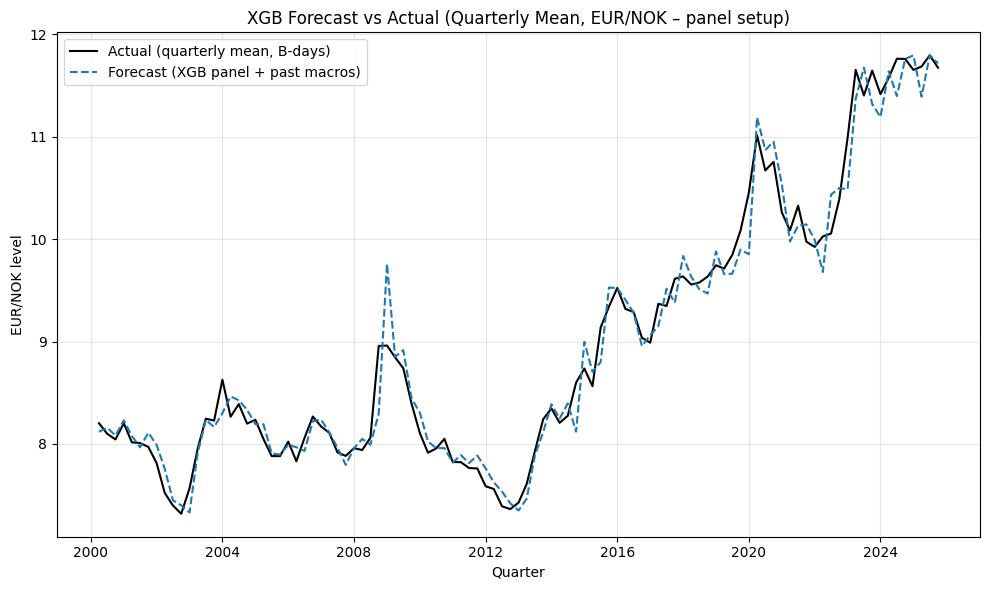

Saved PNG: XGB_PriceOnly_Quarterly_PanelPastCov.png


In [8]:
# =========================================
# XGB Price only – EUR/NOK walk-forward (quarterly, levels) with daily panel + macro covariates
# ROUND 1 (quarterly):
#   - Baseline quarterly walk-forward on ALL covariates
#   - DM vs Random Walk (MSE, h=1)
#   - Leave-one-out DM p-value importance on covariates (EUR_NOK lags always kept)
#   - Output: save ONLY PNG as "XGB_PriceOnly_Quarterly_PanelPastCov.png"
# =========================================

!pip -q install pandas numpy scikit-learn matplotlib requests certifi joblib xgboost

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List

import numpy as np
import pandas as pd
import requests, certifi
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed


# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )

    q_freq: str = "Q-DEC"     # quarterly evaluation
    max_lags: int = 20        # daily lags per predictor
    max_horizon: int = 128    # must exceed longest quarter (~92 days)

    # XGB hyperparameters (cap <= 150)
    n_estimators: int = 150
    learning_rate: float = 0.08
    max_depth: int = 3
    subsample: float = 0.8
    colsample_bytree: float = 0.8
    min_child_weight: float = 3.0
    gamma: float = 0.05
    reg_alpha: float = 0.0
    reg_lambda: float = 2.0
    random_state: int = 42

    retries: int = 3
    timeout: int = 60
    verbose: bool = True

    fig_png: str = "XGB_PriceOnly_Quarterly_PanelPastCov.png"

CFG = Config()

TARGET_SERIES = "EUR_NOK"

PANEL_SERIES = [
    "EUR_NOK",
    "Brent",
    "VIX",
    "StoxEurope",
    "SP500",
    "OSEBX",
    "OBX_Energy",
]
MACRO_COLS = ["Q", "d_pi", "dI_t"]

# Kovariater (leave-one-out kjøres på disse)
ALL_COV_COLS = [c for c in PANEL_SERIES + MACRO_COLS if c != TARGET_SERIES]

# Predictors som faktisk lagges i modellen = EUR_NOK + alle kovariater
ALL_PREDICTORS = [TARGET_SERIES] + ALL_COV_COLS


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with simple retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading: daily wide DF + EUR_NOK business-day series
# -----------------------------
def load_series(url: str, predictors: List[str]) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Expected columns:
      Date, EUR_NOK + predictors

    Returns:
      S_b  : EUR_NOK on business days (B) ffilled (cuts + truth)
      DF_d : daily (D) wide DataFrame with predictors, calendar days, ffilled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date"} | set(predictors)
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    for col in predictors:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    if df.empty:
        raise ValueError("Dataset is empty after cleaning.")

    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# Feature engineering: multivariate lag matrix
# -----------------------------
def make_lag_matrix(df_hist: pd.DataFrame, predictors: List[str], max_lags: int):
    """
    X_t = lags of all predictors
    y_t = EUR_NOK_t
    """
    work = df_hist[predictors].copy()
    lag_cols: List[str] = []

    for var in predictors:
        for k in range(1, max_lags + 1):
            name = f"{var}_lag{k}"
            work[name] = work[var].shift(k)
            lag_cols.append(name)

    work = work.dropna()
    if work.empty:
        return np.empty((0, 0)), np.empty((0,)), lag_cols

    X = work[lag_cols].values
    y = work[TARGET_SERIES].values
    return X, y, lag_cols


# -----------------------------
# XGBoost one-step model
# -----------------------------
def fit_xgb_one_step(df_hist_daily: pd.DataFrame, predictors: List[str]) -> Tuple[XGBRegressor, List[str]]:
    X, y, lag_cols = make_lag_matrix(df_hist_daily, predictors, CFG.max_lags)

    if len(X) < 5:
        raise ValueError("Too few observations after lagging to fit model.")

    model = XGBRegressor(
        n_estimators=CFG.n_estimators,
        learning_rate=CFG.learning_rate,
        max_depth=CFG.max_depth,
        subsample=CFG.subsample,
        colsample_bytree=CFG.colsample_bytree,
        min_child_weight=CFG.min_child_weight,
        gamma=CFG.gamma,
        reg_alpha=CFG.reg_alpha,
        reg_lambda=CFG.reg_lambda,
        objective="reg:squarederror",
        eval_metric="rmse",
        tree_method="hist",
        random_state=CFG.random_state,
        n_jobs=1
    )
    model.fit(X, y)
    return model, lag_cols


def recursive_daily_forecast(
    model: XGBRegressor,
    df_hist_daily: pd.DataFrame,
    predictors: List[str],
    H: int
) -> pd.Series:
    """
    Anti-leakage:
      - non-target predictors frozen at last observed level
      - only EUR_NOK updated recursively
    """
    hist = df_hist_daily[predictors].copy()
    last_vals = hist.iloc[-1].to_dict()

    preds = []
    for _ in range(H):
        if len(hist) < CFG.max_lags:
            raise ValueError("Not enough history for lag features.")

        row_feats = []
        for var in predictors:
            lags = hist[var].iloc[-CFG.max_lags:][::-1].values
            row_feats.extend(lags.tolist())

        x = np.array(row_feats, dtype=float).reshape(1, -1)
        yhat = float(model.predict(x)[0])
        preds.append(yhat)

        new_row = last_vals.copy()
        new_row[TARGET_SERIES] = yhat
        new_idx = hist.index[-1] + pd.Timedelta(days=1)
        hist = pd.concat([hist, pd.DataFrame([new_row], index=[new_idx])])

    return pd.Series(preds)


# -----------------------------
# Quarterly walk-forward (parallel outer loop)
# -----------------------------
def walk_forward_xgb_quarterly_parallel(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    predictors: List[str],
    n_jobs_outer: int = -1,
    backend: str = "loky"
) -> pd.DataFrame:
    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(), freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    def _process_one_quarter(q: pd.Period):
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            return (str(q), None, "no_cut_in_prev_quarter")

        hist_df = DF_d.loc[:cut]
        if hist_df.shape[0] <= CFG.max_lags + 5:
            return (str(q), None, "hist<=max_lags")

        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            return (str(q), None, "no_bdays_in_quarter")
        y_true = float(S_b.loc[idx_q_b].mean())

        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            return (str(q), None, f"horizon_invalid(H={H})")

        model, _ = fit_xgb_one_step(hist_df, predictors)
        pf = recursive_daily_forecast(model, hist_df, predictors, H)

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf.values, index=f_idx, name="point")

        pred_b = pred_daily.reindex(idx_q_b)
        if pred_b.isna().all():
            return (str(q), None, "no_overlap_pred_B_days")
        y_pred = float(pred_b.dropna().mean())

        row = {"quarter": q, "cut": cut, "y_true": y_true, "y_pred": y_pred}
        return (str(q), row, None)

    results = Parallel(n_jobs=n_jobs_outer, backend=backend)(
        delayed(_process_one_quarter)(q) for q in quarters
    )

    rows: Dict[str, dict] = {}
    dropped: Dict[str, str] = {}
    for key, row, reason in results:
        if row is not None:
            rows[key] = row
        else:
            dropped[key] = reason or "unknown"

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("quarter").sort_index()

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if str(q) not in rows]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")

    return df


# -----------------------------
# Evaluation
# -----------------------------
def evaluate(eval_df: pd.DataFrame, silent: bool = False) -> pd.DataFrame:
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    if not silent:
        print("\n=== Model performance (quarterly mean, EUR/NOK – XGB panel + past macro covariates) ===")
        print(f"Observations: {n_obs}")
        print(f"RMSE (level): {rmse:.6f}")
        print(f"MAE  (level): {mae:.6f}")
        if total:
            print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core


# -----------------------------
# Diebold–Mariano (vs Random Walk)
# -----------------------------
def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse"
) -> Tuple[float, float]:
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> Tuple[float, float]:
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (XGB panel setup, quarterly) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")
    return dm_stat, p_val


# -----------------------------
# Leave-one-out DM p-value importance (ROUND 1)
# -----------------------------
def dm_pvalue_for_covset(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    predictors: List[str],
) -> Tuple[float, float]:
    df_eval = walk_forward_xgb_quarterly_parallel(S_b, DF_d, predictors, n_jobs_outer=-1)
    ev = evaluate(df_eval, silent=True)
    ev["rw_pred"] = ev["y_true"].shift(1)
    dm_stat, p_val = dm_test(ev["y_true"], ev["y_pred"], ev["rw_pred"], h=1, loss="mse")
    return dm_stat, p_val


def pvalue_importance_leave_one_out(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    base_predictors: List[str],
    cov_cols_only: List[str],
) -> Tuple[float, float, pd.DataFrame]:
    """
    Leave-one-out on covariates only (EUR_NOK lags always kept).
    delta_p = p_without - p_baseline.
    """
    base_stat, base_p = dm_pvalue_for_covset(S_b, DF_d, base_predictors)

    rows = []
    for c in cov_cols_only:
        reduced_cov = [x for x in cov_cols_only if x != c]
        reduced_predictors = [TARGET_SERIES] + reduced_cov
        stat_i, p_i = dm_pvalue_for_covset(S_b, DF_d, reduced_predictors)

        rows.append({
            "covariate": c,
            "p_without": p_i,
            "delta_p": p_i - base_p,
            "dm_without": stat_i
        })

    out = pd.DataFrame(rows).sort_values("delta_p", ascending=False).reset_index(drop=True)
    return base_stat, base_p, out


# -----------------------------
# Plot (PNG only)
# -----------------------------
def plot_quarterly_simple(eval_df: pd.DataFrame, png_path: str):
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (quarterly mean, B-days)")
    plt.plot(
        x, eval_df["y_pred"],
        color="tab:blue", linestyle="--",
        label="Forecast (XGB panel + past macros)"
    )

    plt.title("XGB Forecast vs Actual (Quarterly Mean, EUR/NOK – panel setup)")
    plt.xlabel("Quarter")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved PNG: {png_path}")


# -----------------------------
# Main (ROUND 1)
# -----------------------------
def main():
    # Load full predictor set (EUR_NOK + all covariates)
    predictors_base = ALL_PREDICTORS
    S_b, DF_d = load_series(CFG.url, predictors_base)

    if CFG.verbose:
        print(f"Covariates (ROUND 1): {ALL_COV_COLS}")
        print(f"Predictors used (with lags): {predictors_base}")
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    # Baseline quarterly walk-forward
    df_eval_base = walk_forward_xgb_quarterly_parallel(S_b, DF_d, predictors_base, n_jobs_outer=-1)
    eval_df_base = evaluate(df_eval_base, silent=False)

    # DM vs RW baseline
    dm_stat_base, dm_p_base = dm_against_random_walk(eval_df_base, loss="mse", h=1)

    # Leave-one-out importance on covariates only
    base_stat2, base_p2, p_imp = pvalue_importance_leave_one_out(
        S_b, DF_d,
        base_predictors=predictors_base,
        cov_cols_only=ALL_COV_COLS
    )

    print("\n=== DM p-value importance (leave-one-out, quarterly | ROUND 1 on full set) ===")
    print(f"Baseline DM-stat: {base_stat2:.4f} | p={base_p2:.4f}\n")
    print(p_imp.to_string(index=False))

    important_r1 = p_imp.loc[p_imp["delta_p"] > 0, "covariate"].tolist()
    print(f"\nSuggested important covariates for ROUND 2 (delta_p>0): {important_r1}")

    # Plot + save
    plot_quarterly_simple(eval_df_base, CFG.fig_png)


if __name__ == "__main__":
    main()
